In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

We were tasked to develop an automated email filtering system that can accurately distinguish between legitamate emails (ham) and commercial/promotional emails (spam). The system should analyze the incoming email content, and minimize exposure to unwanted spam messages.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [27]:
import os
import pandas as pd


def load_and_explore(data_folder_path):
    emails = []
    labels = []
    filenames = []
    
    # Load spam emails
    spam_folder = os.path.join(data_folder_path, 'spam')
    spam_count = 0
    for filename in os.listdir(spam_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(spam_folder, filename), 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
            emails.append(content)
            labels.append('spam')
            filenames.append(filename)
            spam_count += 1
    
    # Load ham emails
    ham_folder = os.path.join(data_folder_path, 'ham')
    ham_count = 0
    for filename in os.listdir(ham_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(ham_folder, filename), 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
            emails.append(content)
            labels.append('ham')
            filenames.append(filename)
            ham_count += 1
            # Create DataFrame
        df = pd.DataFrame({
        'filename': filenames,
        'email': emails,
        'label': labels
    })
    
    return df, spam_count, ham_count

    
    

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

Dataset: 872 emails (391 spam, 481 ham)

Top spam words: ['3d', 'money', 'business', 'report', 'free']
Top ham words: ['subject', 'http', 'work', 'address', 'send']

Pattern frequencies:
       has_dollar  has_exclamation  has_url
label                                      
ham      0.126819         0.151767      0.0
spam     0.572890         0.815857      0.0


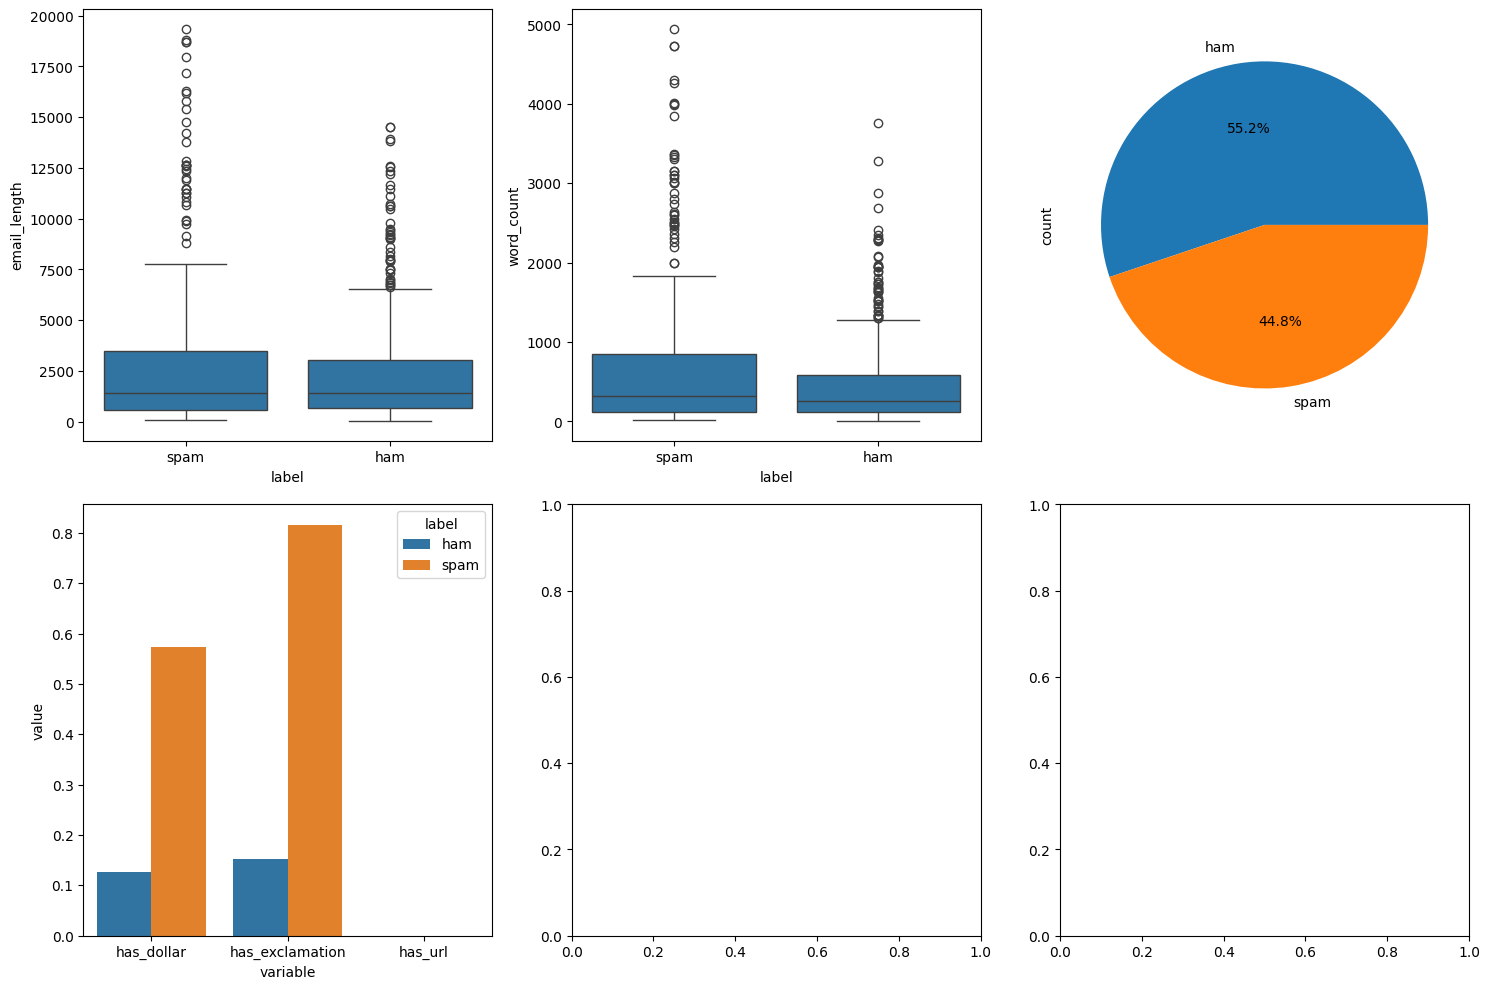

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Load data
def load_emails(data_folder):
    emails, labels, filenames = [], [], []
    for label in ['spam', 'ham']:
        folder_path = os.path.join(data_folder, label)
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8', errors='ignore') as f:
                    emails.append(f.read())
                    labels.append(label)
                    filenames.append(filename)
    return pd.DataFrame({'filename': filenames, 'email': emails, 'label': labels})

# Load and basic info
df = load_emails('data')
print(f"Dataset: {len(df)} emails ({df['label'].value_counts()['spam']} spam, {df['label'].value_counts()['ham']} ham)")

# Basic metrics
df['email_length'] = df['email'].apply(len)
df['word_count'] = df['email'].apply(lambda x: len(x.split()))
df['has_dollar'] = df['email'].apply(lambda x: 1 if '$' in x else 0)
df['has_exclamation'] = df['email'].apply(lambda x: 1 if '!' in x else 0)
df['has_url'] = df['email'].apply(lambda x: 1 if re.search(r'http[s]?://', x) else 0)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(data=df, x='label', y='email_length', ax=axes[0,0])
sns.boxplot(data=df, x='label', y='word_count', ax=axes[0,1])
df['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0,2])
sns.barplot(data=df.groupby('label')[['has_dollar','has_exclamation','has_url']].mean().reset_index().melt(id_vars='label'), 
            x='variable', y='value', hue='label', ax=axes[1,0])

# Word frequency analysis
vectorizer = CountVectorizer(stop_words='english', max_features=20)
spam_words = vectorizer.fit_transform(df[df['label']=='spam']['email'])
ham_words = vectorizer.transform(df[df['label']=='ham']['email'])
word_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'spam_freq': np.array(spam_words.sum(axis=0))[0],
    'ham_freq': np.array(ham_words.sum(axis=0))[0]
})
word_df['spam_ratio'] = word_df['spam_freq'] / word_df['ham_freq']
print("\nTop spam words:", word_df.nlargest(5, 'spam_ratio')['word'].tolist())
print("Top ham words:", word_df.nsmallest(5, 'spam_ratio')['word'].tolist())

# Pattern analysis
pattern_stats = df.groupby('label')[['has_dollar','has_exclamation','has_url']].mean()
print(f"\nPattern frequencies:\n{pattern_stats}")
plt.tight_layout()
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [29]:
# STEP 4: PREPARE THE DATA
import re

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_email'] = df['email'].apply(clean_text)

# Remove duplicates and really short emails
df = df[df['cleaned_email'].str.len() > 20]
df = df.drop_duplicates(subset=['cleaned_email'])
print(f"After cleaning: {len(df)} emails")

# Feature engineering
def extract_simple_features(text):
    features = {}
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    features['has_dollar'] = 1 if '$' in text else 0
    features['has_exclamation'] = 1 if '!' in text else 0
    features['has_urgent'] = 1 if 'urgent' in text else 0
    features['has_free'] = 1 if 'free' in text else 0
    return features

# Extract features
feature_data = [extract_simple_features(text) for text in df['cleaned_email']]
features_df = pd.DataFrame(feature_data)
df_processed = pd.concat([df.reset_index(drop=True), features_df], axis=1)


After cleaning: 864 emails


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 
